# VAR Bayesiano (BVAR)
Seguiremos a [BGR2010](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137) en su propuesta Large BVAR

Los autores introducen el prior de Litterman (o Minnesota Prior) con observación 'dummy' al inicio de la muestra

In [37]:
import numpy as np # Algebra matricial
import datetime as dt
import pandas as pd
import random # Simulacion aleatoria
import matplotlib.pyplot as plt # gráficos
import time
import sys

## Añadir librería creada
Añadir la librería creada para esta parte del curso

In [38]:
flag_runlocal  = False    # "False" para ejecutar en google colab
flag_useserver = True    # "False" para ejecutar con conexión a internet via proxy

In [39]:
if flag_runlocal:
    # ---> Ejecución local
    pathBayesInfer = ''
    if flag_useserver:
        from ConfigProxy import proxy
        # Set the proxy with authentication
        import os
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

else:
    # ---> Desde github-to-colab
    !git clone https://github.com/Alledar/BayesInfer.git
    pathBayesInfer = '/content/BayesInfer/'

sys.path.append(pathBayesInfer+'02_Libraries')
import VARstuff

fatal: destination path 'BayesInfer' already exists and is not an empty directory.


1. Cargar la data (disponible [aquí](http://qed.econ.queensu.ca/jae/datasets/banbura001/))

In [40]:
df_raw = pd.read_csv(pathBayesInfer + '03_Inputs/bgrdata.csv')
df_info = pd.read_csv(pathBayesInfer + '03_Inputs/info.csv')

In [41]:
df_raw.head()

,A0M052,A0M051,A0M224_R,A0M057,A0M059,IPS10,IPS11,IPS299,IPS12,IPS13,...,PUXHS,PUXM,GMDC,GMDCD,GMDCN,GMDCS,CES275,CES277,CES278,HHSNTN
0,1971.0,1852.5,1485.538800,222317,62732,30.126,28.706,28.269,34.890,24.669,...,31.1,29.9,21.817,41.932,24.730,16.993,2.22,2.57,2.13,101.7
1,1972.1,1853.2,1491.689941,220894,62474,29.858,28.544,28.172,34.492,24.330,...,31.1,30.0,21.841,41.994,24.744,17.020,2.23,2.59,2.14,104.6
2,1975.2,1854.0,1513.016425,218935,62739,29.590,28.446,28.140,34.532,23.849,...,31.1,30.0,21.857,41.839,24.791,17.036,2.24,2.69,2.14,102.6
3,1980.6,1859.4,1536.357420,220369,64449,29.355,28.511,28.172,34.771,23.821,...,31.2,30.1,21.935,41.885,24.926,17.073,2.24,2.61,2.14,100.6
4,1985.1,1863.6,1505.533039,216272,62779,29.322,28.674,28.366,34.969,24.047,...,31.3,30.1,21.959,41.871,24.911,17.133,2.24,2.64,2.14,98.6


In [42]:
OrderFinal = df_info.Mnemon.values
k0 = OrderFinal.size

df_ordered = df_raw[OrderFinal].copy()
df_ordered.head()

,CES002,PUNEW,PSM99Q,A0M051,A0M224_R,IPS10,A0M082,LHUR,HSFR,PWFSA,...,SFYGM6,SFYGT1,SFYGT5,SFYGT10,SFYAAAC,SFYBAAC,EXRSW,EXRJAN,EXRUK,EXRCAN
0,45967,29.37,31.64,1852.5,1485.538800,30.126,85.56,5.2,1460,33.1,...,0.75,1.04,0.93,0.73,0.62,1.35,4.3268,360.36,279.9756,0.9532
1,46187,29.41,31.46,1853.2,1491.689941,29.858,84.61,4.8,1503,33.1,...,0.33,0.69,0.72,0.52,0.59,1.37,4.3375,360.62,280.3289,0.9518
2,45933,29.41,31.08,1854.0,1513.016425,29.590,83.24,5.4,1109,33.4,...,-0.23,0.18,0.47,0.41,0.65,1.41,4.3368,360.62,280.5857,0.9510
3,46278,29.54,31.17,1859.4,1536.357420,29.355,82.26,5.2,1289,33.4,...,-0.37,0.12,0.37,0.36,0.53,1.28,4.3387,360.23,280.9495,0.9630
4,46040,29.57,31.11,1863.6,1505.533039,29.322,81.47,5.1,1271,33.4,...,-0.27,0.36,0.64,0.50,0.61,1.43,4.3245,360.49,280.6006,0.9780


In [43]:
TakeLog = df_info['Log'].values.astype(bool)
for ii in range(k0):
    if TakeLog[ii]:
        df_ordered[OrderFinal[ii]] = np.log(df_ordered[OrderFinal[ii]])

df_ordered.head()

,CES002,PUNEW,PSM99Q,A0M051,A0M224_R,IPS10,A0M082,LHUR,HSFR,PWFSA,...,SFYGM6,SFYGT1,SFYGT5,SFYGT10,SFYAAAC,SFYBAAC,EXRSW,EXRJAN,EXRUK,EXRCAN
0,10.735679,3.379974,3.454422,7.524291,7.303533,3.405389,85.56,5.2,7.286192,3.499533,...,0.75,1.04,0.93,0.73,0.62,1.35,1.464828,5.887104,5.634702,-0.047931
1,10.740454,3.381335,3.448717,7.524669,7.307665,3.396453,84.61,4.8,7.315218,3.499533,...,0.33,0.69,0.72,0.52,0.59,1.37,1.467298,5.887825,5.635964,-0.049400
2,10.734939,3.381335,3.436565,7.525101,7.321861,3.387436,83.24,5.4,7.011214,3.508556,...,-0.23,0.18,0.47,0.41,0.65,1.41,1.467137,5.887825,5.636879,-0.050241
3,10.742422,3.385745,3.439456,7.528009,7.337170,3.379463,82.26,5.2,7.161622,3.508556,...,-0.37,0.12,0.37,0.36,0.53,1.28,1.467575,5.886743,5.638175,-0.037702
4,10.737266,3.386760,3.437529,7.530265,7.316902,3.378338,81.47,5.1,7.147559,3.508556,...,-0.27,0.36,0.64,0.50,0.61,1.43,1.464297,5.887464,5.636932,-0.022246


In [44]:
df_final = df_ordered.copy()
df_info_final = df_info.copy()

In [45]:
T = df_final.CES002.size
T

528

In [46]:

H = 12
df_estimate = df_final[0:(T-H)].copy()
df_eval = df_final[(T-H-1):T].copy()

2. Preparando los datos para procedimientos Bayesianos

In [47]:
lag = 13
k = df_final.columns.size
data2est = df_estimate.values
y,X,k,Tf = VARstuff.get_yXform(data2est,lag)

y2e = df_eval.values

In [36]:
y.shape

(503, 131)

3. Estimación y pronóstico simple

In [19]:
Bhat,Sigmahat,yhat,uhat = VARstuff.get_MCO_VAR(y,X)
Xtp1 = X[Tf-1,:]
y_data = y2e
y_data_first = y2e[0,:]
y_data_first.shape = (1,k)

In [20]:
u_zero = np.zeros(shape=(H,k))
y_zero,_ = VARstuff.get_sim_VAR(Xtp1,u_zero,Bhat,lag)
y_zero = np.r_[y_data_first,y_zero]

4. Concentremonos en las variables correspondientes a CEE2005

In [21]:
CEEindex0 = df_info_final['CEE'].values.astype(bool)
aux0 = CEEindex0.nonzero()
CEEindex = aux0[0]
CEEname  = df_final.columns[CEEindex0]

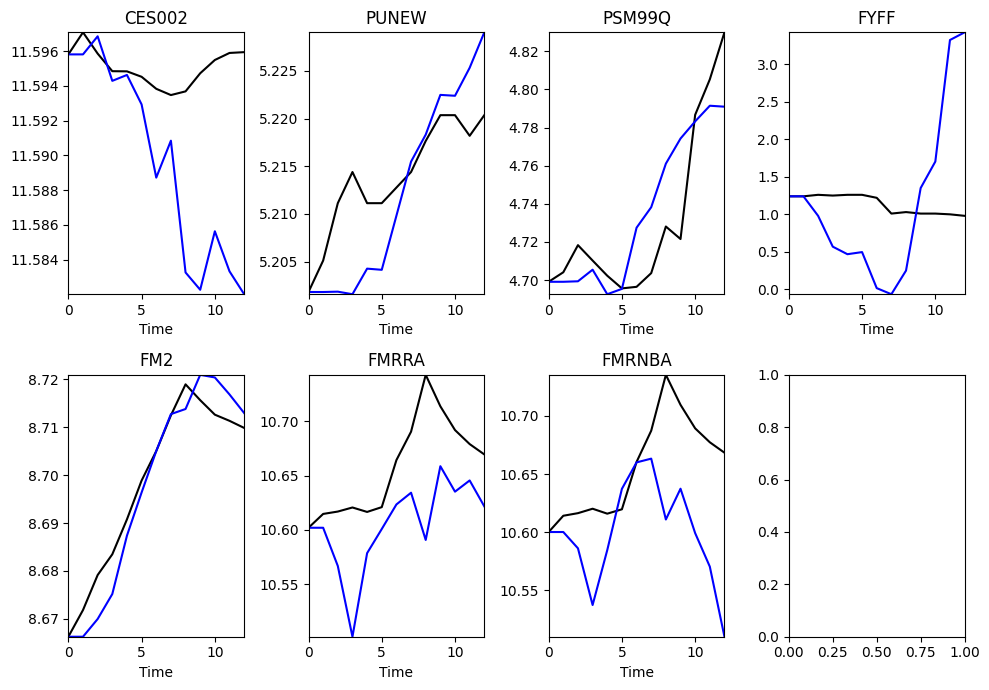

In [22]:
fig, axs = plt.subplots(2,4,figsize=(10,7))
ff = 0
for rr in range(2):
    for cc in range(4):
        if ff<7:
            axs[rr,cc].plot(y_data[:,CEEindex[ff]],'k')
            axs[rr,cc].plot(y_zero[:,CEEindex[ff]],'b')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

plt.tight_layout()

5. Extendiendo la data con observaciones 'dummy' (BGR2012 sugieren $\tau=10\lambda$)

In [23]:
# Minnesota prior
lmbda = 0.035
deltas = df_info_final['RW'].values
sigmas = VARstuff.get_sigmas(data2est,lag)
yd0,Xd0,Td = VARstuff.get_DumObsLitterman(lmbda,deltas,sigmas,lag)

# Sum of coefficients prior
tau = 10*lmbda
mus = np.mean(data2est,0)
yd1,Xd1,Td1 = VARstuff.get_DumObsSumCoef(tau, mus, sigmas, lag)

# data extended
y_star = np.r_[yd0,yd1,y]
X_star = np.r_[Xd0,Xd1,X]

0 litterman
1 coeficients sum
y normal

6. Some posterior moments

In [24]:
Bayes = True
B_post,Sigma_post,_,_ = VARstuff.get_MCO_VAR(y_star,X_star,Bayes)
Tf_post,d = X_star.shape
Dof_post = Tf_post-k # Tf_post-d ?
LT_SS_post = np.linalg.cholesky(Sigma_post)
XX_star = np.dot(np.transpose(X_star),X_star)
LT_P_post =  VARstuff.get_iXXchol(XX_star)

7. Pronóstico simple (como en BGR2010)

In [25]:
y_zero_m,_ = VARstuff.get_sim_VAR(Xtp1,u_zero,B_post,lag)
y_zero_m = np.r_[y_data_first,y_zero_m]

8. Pronóstico Bayesiano

In [26]:
random.seed( 0 )    # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
Fore_BVAR = VARstuff.get_BVARforvast(y_data_first,Xtp1,lag,H,100,1000,B_post,LT_SS_post,LT_P_post,Dof_post)
#Fore_BVAR = VARstuff.get_BVARforvast(y_data_first,Xtp1,lag,H,10,100,B_post,LT_SS_post,LT_P_post,Dof_post)

[                                                  ]
[--------------------------------------------------]



In [27]:
Fore_BVAR_Q95  = np.percentile(Fore_BVAR, 95, axis=2)
Fore_BVAR_Q05  = np.percentile(Fore_BVAR,  5, axis=2)
Fore_BVAR_mean = np.mean(Fore_BVAR,axis=2)

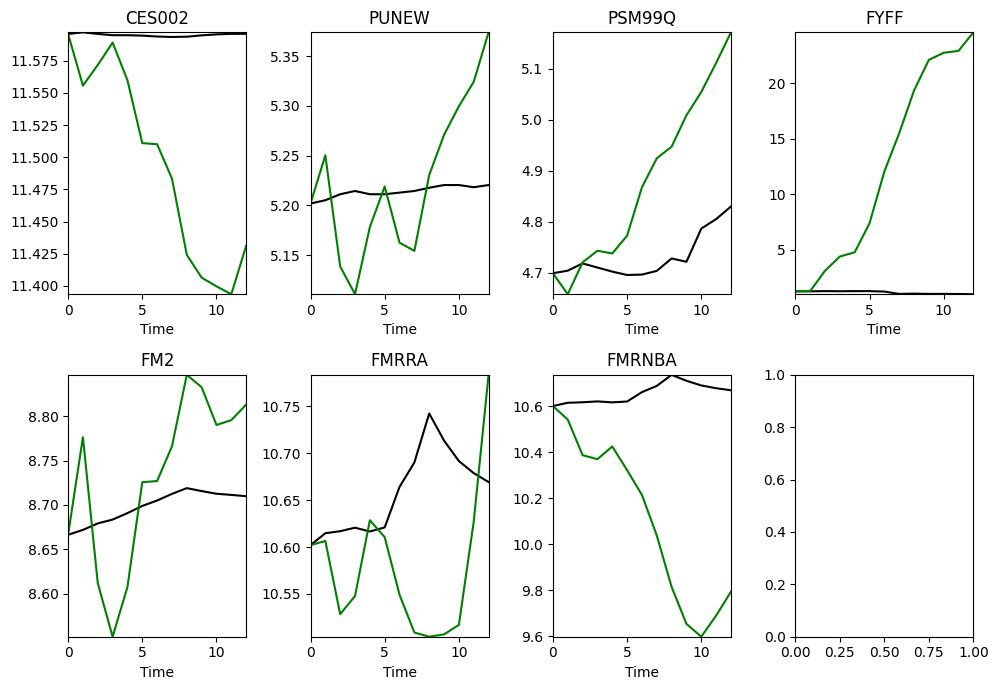

In [28]:
fig, axs = plt.subplots(2,4,figsize=(10,7))
ff = 0
for rr in range(2):
    for cc in range(4):
        if ff<7:
            axs[rr,cc].plot(y_data[:,CEEindex[ff]],'k')
            #axs[rr,cc].plot(y_zero_m[:,CEEindex[ff]],'b')
            axs[rr,cc].plot(Fore_BVAR_mean[:,CEEindex[ff]],'g')
            #axs[rr,cc].plot(Fore_BVAR_Q95[:,CEEindex[ff]],'r')
            #axs[rr,cc].plot(Fore_BVAR_Q05[:,CEEindex[ff]],'r')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

plt.tight_layout()

In [29]:
Ferror_freq = np.linalg.norm(y_data-y_zero)/y_data.size
Ferror_simple = np.linalg.norm(y_data-y_zero_m)/y_data.size
Ferror_bayes = np.linalg.norm(y_data-Fore_BVAR_mean)/y_data.size
print('Freq:')
print(Ferror_freq)
print('')
print('Simple:')
print(Ferror_simple)
print('Bayes:')
print(Ferror_bayes)

Freq:
0.2932095206817752

Simple:
0.23317203649922844
Bayes:
1.9880444796141634


9. IRF
Similar a CEE

In [30]:
aux0=df_final.columns=='FYFF'
aux0 = aux0.nonzero()
shock = aux0[0]+1
scale = 1

In [31]:
Bhat, Sigmahat, _, uhat = VARstuff.get_MCO_VAR(y, X)

In [32]:
h=4*12
b=1
r=50
nsample = 50
random.seed( 0 )    # Fijando la semilla (reproducir resultados)
np.random.seed( 0 ) # Fijando la semilla (reproducir resultados)
#IRF = VARstuff.get_IRF_Chol_BT(y_star,X_star,k,Tf,nsample,h,shock,lag,scale)
startC = time.time()
IRF = VARstuff.get_IRF_Chol_BVAR(lag,h,b,r,B_post,LT_SS_post,LT_P_post,Dof_post,95,scale)
endC = time.time()
print('Time elapsed:',endC-startC)


[                                                  ]
[----------------------------------------------------]

Time elapsed: 38.63252401351929


In [33]:
IRF_Q95  = np.percentile(IRF, 95, axis=2)
IRF_Q05  = np.percentile(IRF,  5, axis=2)
IRF_mean = np.mean(IRF,axis=2)

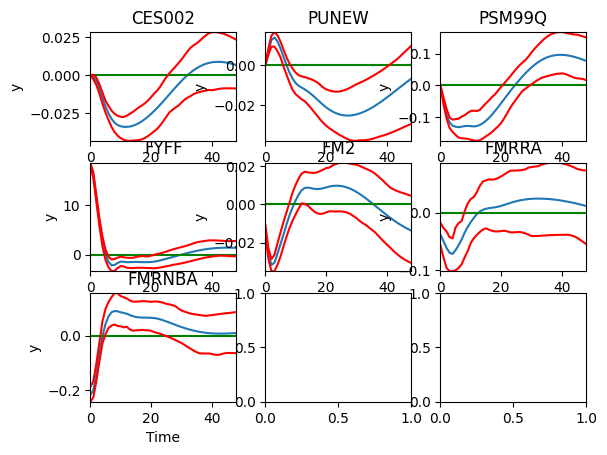

In [34]:
fig, axs = plt.subplots(3,3)

ff = 0
for rr in range(3):
    for cc in range(3):
        if ff<7:
            axs[rr,cc].plot(IRF_mean[CEEindex[ff],:]*100)
            axs[rr,cc].axhline(0, color='green')
            axs[rr,cc].plot(IRF_Q95[CEEindex[ff],:]*100,'r')
            axs[rr,cc].plot(IRF_Q05[CEEindex[ff],:]*100,'r')
            axs[rr,cc].set_xlabel('Time')
            axs[rr,cc].set_ylabel('y')
            axs[rr,cc].set_title(CEEname[ff])
            axs[rr,cc].autoscale(enable=True, axis='both', tight=True)
            ff += 1

#plt.tight_layout()

In [35]:
np.asarray([VARstuff.Hyper_ML(np.asarray([lmbda-0.01]), X, y, sigmas, deltas), VARstuff.Hyper_ML(np.asarray([lmbda]), X, y, sigmas, deltas), VARstuff.Hyper_ML(np.asarray([lmbda+0.5]), X, y, sigmas, deltas)])

array([-161847.2078099 , -154775.31034082,  -16752.24207295])

# Reference
> Banbura, Giannone y Reichlin (2010), *Large Bayesian vector auto regressions*. Journal of Applied Econometrics, John Wiley & Sons, Ltd., vol. 25(1), pages 71-92, January. [https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1137)
